# Week 4 Mini Project

### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install opendatasets

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
import keras_nlp
from keras import regularizers
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
od.download("https://www.kaggle.com/c/nlp-getting-started/data")

## Introduction

The purpose of this project is to build a machine learning model that predits which tweets are about real disasters and which ones are not about real disasters. The tweets include the 'text' of what the tweet actually says, the 'keyword' and 'location' of the tweet, which may be blank, and then the 'target' value, if the tweet is about a real disaster.

### Data Ingestion

We will start by reading in the training dataset. This csv has over 7,000 tweets that contain the text of the tweet as well as the target value. If the target value is 1, then the tweet is about a real disaster. If the target value is 0, then the tweet is not about a real disaster. We will create a dataframe containing the training data and a separate dataframe containing the test data for future use, which doesn't contain any target values.

In [5]:
df = pd.read_csv('nlp-getting-started/train.csv')
print(df.shape)
df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test = pd.read_csv('nlp-getting-started/test.csv')
print(df_test.shape)
df_test.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Exploratory Data Analysis

First, we will investigate how many null values there are in the dataset. From the plots below, we can see there are 61 missing 'keyword' values and 2533 missing 'location' values.

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


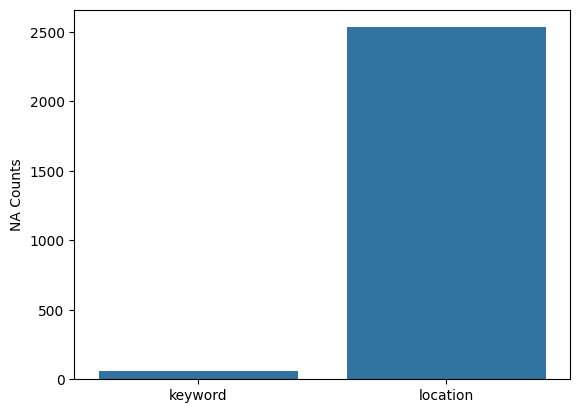

In [7]:
print(df.isnull().sum())
ax = sns.barplot(x=df[['keyword','location']].isnull().sum().index, y=df[['keyword','location']].isnull().sum().values)
ax.set_ylabel("NA Counts")
ax.set_xlabel(None)
plt.show()

We are model to be able to train on all the inputs that don't have missing data so we will drop all the missing 'location' and 'keyword' values. After those are removed, we can see there are just above 5,000 tweets remaining.

In [8]:
df = df.dropna()
print(df.isnull().sum())
print(df.shape)

id          0
keyword     0
location    0
text        0
target      0
dtype: int64
(5080, 5)


Now we will inspect how many positive and negative targets we have. We can see that about 43% of the targets are positive(1) and 57% of the targets are negative (0). This is slightly unbalanced.

Percentage of Positive Labels:  43.22834645669291


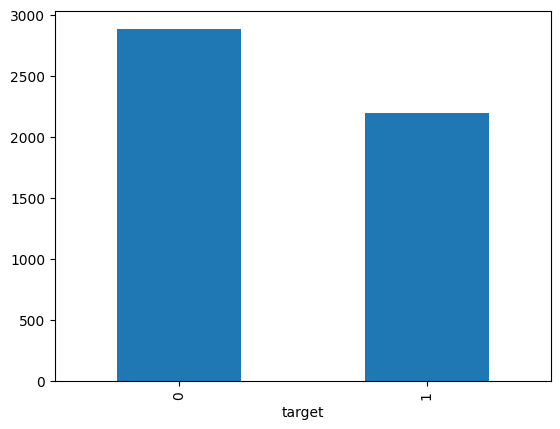

In [9]:
df['target'].value_counts().plot(kind="bar")
print("Percentage of Positive Labels: ", 100* len(df[df['target']==1])/len(df))

In order balance out our dataset and decrease bias for our model, we will take a random sample of 2,000 tweets from each target and use that for our training and validation data.

<Axes: xlabel='target'>

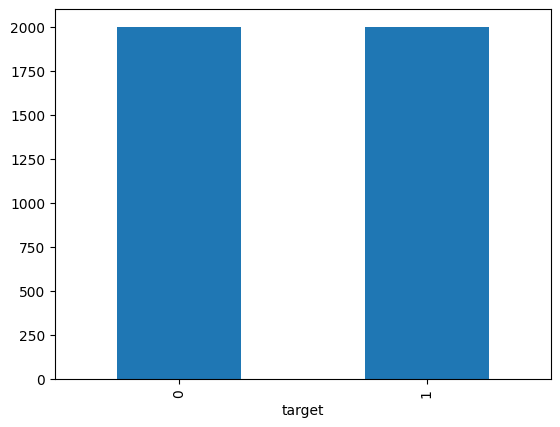

In [10]:
df_0 = df[df['target']==0].sample(2000,random_state=1)
df_1 = df[df['target']==1].sample(2000,random_state=1)

df = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

df['target'].value_counts().plot(kind="bar")

Based on this EDA, we have ensured that we have a balanced dataset that doesn't have any missing values for our model to train on.

For a plan of analysis, we will create a model using a pretrained FNet model which is good for natural language processing and evaluate the model based on accuracy and F1 score.

## Model Architecture

In order to find the best model for this problem, we will tune hyperparameters on the learning rate as well as the batch size. We will do an 80% training set split to a 20% validation set split and create a test set.

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(df["text"], df["target"], test_size=0.20, random_state=1)
x_test = df_test["text"]

print(x_train.shape)
print(x_valid.shape)

(3200,)
(800,)


### Model Description

The models we will test will be based on the FNet neural network. The FNet architecture uses a Fourier Transform to capture relationships between words rather than using self-attention like other NLP models, like the popular BERT model. The Fourier series transforms the input into the frequency domain from the time domain. This methods allows FNet to be more efficient than other NLP models while still having similar results. We will build a FNet preprocessor using a pre-trained FNet model and then build a corresponding classifier that we will fit and evaluate. We will also compile the models using an Adam optimtizer with a variable learning rate and a loss function of sparse categorical crossentropy.

### Hyperparamters

The hyperparameters tuned for this project will be the number of batches used for fitting and the learning rate. There will be 3 models compiled using different batch sizes of 32, 16, and 8. The learning rate will be tuned during the model fitting stage using the ReduceLROnPlateau tool. The learning rate will start out at 0.001 and as the model is fit, the learning rate will lower by 0.1 every time a plateau is reached. Thus, each model can find the most approriate learning rate.

### Model 1 - Batch Size 32

In [38]:
preprocessor = keras_nlp.models.FNetPreprocessor.from_preset("f_net_base_en", sequence_length=128)
model1 = keras_nlp.models.FNetClassifier.from_preset("f_net_base_en", preprocessor = preprocessor, num_classes=2)

model1.summary()

Preprocessor: "f_net_text_classifier_preprocessor_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ f_net_tokenizer (FNetTokenizer)                               │                       Vocab size: 32,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "f_net_text_classifier_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ f_net_backbone (FNetBackbone) │ [(None, 768), (None,      │      82,861,056 │ segment_ids[0][0],         │
│                               │ None, 768)]               │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ f_net_backbone[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 82,862,594 (316.10 MB)

 Trainable params: 82,862,594 (316.10 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model1.compile(optimizer=Adam(learning_rate=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
rd = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history1 = model1.fit(x=x_train,
                     y=y_train,
                     batch_size=32,
                     epochs=6,
                     validation_data=(x_valid, y_valid),
                     callbacks=[rd, es])

Epoch 1/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 113s 635ms/step - accuracy: 0.4986 - loss: 0.8815 - val_accuracy: 0.5188 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.4726 - loss: 0.7092
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 ━━━━━━━━━━━━━━━━━━━━ 112s 546ms/step - accuracy: 0.4727 - loss: 0.7092 - val_accuracy: 0.5188 - val_loss: 0.6945 - learning_rate: 0.0010
Epoch 3/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 566ms/step - accuracy: 0.5038 - loss: 0.6962 - val_accuracy: 0.5188 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 4/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.4883 - loss: 0.6957
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 556ms/step - accuracy: 0.4884 - loss: 0.6957 - val_accuracy: 0.5188 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 5/6
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0

In [40]:
with open('/content/drive/MyDrive/Colab Notebooks/history1.pkl', 'wb') as f:
    pickle.dump(history1.history, f)

with open('/content/drive/MyDrive/Colab Notebooks/model1.pkl', 'wb') as f:
    pickle.dump(model1, f)

### Model 2 - Batch Size 16

In [66]:
preprocessor = keras_nlp.models.FNetPreprocessor.from_preset("f_net_base_en", sequence_length=128)
model2 = keras_nlp.models.FNetClassifier.from_preset("f_net_base_en", preprocessor = preprocessor, num_classes=2)

model2.summary()

Preprocessor: "f_net_text_classifier_preprocessor_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ f_net_tokenizer (FNetTokenizer)                               │                       Vocab size: 32,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "f_net_text_classifier_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ f_net_backbone (FNetBackbone) │ [(None, 768), (None,      │      82,861,056 │ segment_ids[0][0],         │
│                               │ None, 768)]               │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ f_net_backbone[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 82,862,594 (316.10 MB)

 Trainable params: 82,862,594 (316.10 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
rd = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history2 = model2.fit(x=x_train,
                     y=y_train,
                     batch_size=16,
                     epochs=6,
                     validation_data=(x_valid, y_valid),
                     callbacks=[rd, es])

Epoch 1/6
200/200 ━━━━━━━━━━━━━━━━━━━━ 111s 310ms/step - accuracy: 0.4852 - loss: 0.7363 - val_accuracy: 0.5188 - val_loss: 0.6989 - learning_rate: 0.0010
Epoch 2/6
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.4985 - loss: 0.7158
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 271ms/step - accuracy: 0.4986 - loss: 0.7158 - val_accuracy: 0.5188 - val_loss: 0.7164 - learning_rate: 0.0010
Epoch 3/6
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - accuracy: 0.4985 - loss: 0.6985 - val_accuracy: 0.4812 - val_loss: 0.6941 - learning_rate: 1.0000e-04
Epoch 4/6
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.4954 - loss: 0.6953
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 265ms/step - accuracy: 0.4954 - loss: 0.6953 - val_accuracy: 0.4812 - val_loss: 0.6942 - learning_rate: 1.0000e-04
Epoch 5/6
200/200 ━━━━━━━━━━━━━━━━━━━━ 55s 276ms/step - accuracy: 0

In [87]:
with open('/content/drive/MyDrive/Colab Notebooks/history2.pkl', 'wb') as f:
    pickle.dump(history2.history, f)

with open('/content/drive/MyDrive/Colab Notebooks/model2.pkl', 'wb') as f:
    pickle.dump(model2, f)

### Model 3 - Batch Size 8

In [90]:
preprocessor = keras_nlp.models.FNetPreprocessor.from_preset("f_net_base_en", sequence_length=128)
model3 = keras_nlp.models.FNetClassifier.from_preset("f_net_base_en", preprocessor = preprocessor, num_classes=2)

model3.summary()

Preprocessor: "f_net_text_classifier_preprocessor_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ f_net_tokenizer (FNetTokenizer)                               │                       Vocab size: 32,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "f_net_text_classifier_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ f_net_backbone (FNetBackbone) │ [(None, 768), (None,      │      82,861,056 │ segment_ids[0][0],         │
│                               │ None, 768)]               │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ f_net_backbone[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 82,862,594 (316.10 MB)

 Trainable params: 82,862,594 (316.10 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
rd = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history3 = model3.fit(x=x_train,
                     y=y_train,
                     batch_size=8,
                     epochs=6,
                     validation_data=(x_valid, y_valid),
                     callbacks=[rd, es])

Epoch 1/6
400/400 ━━━━━━━━━━━━━━━━━━━━ 115s 170ms/step - accuracy: 0.5075 - loss: 0.8122 - val_accuracy: 0.4812 - val_loss: 0.7796 - learning_rate: 0.0010
Epoch 2/6
400/400 ━━━━━━━━━━━━━━━━━━━━ 115s 154ms/step - accuracy: 0.5091 - loss: 0.7481 - val_accuracy: 0.4812 - val_loss: 0.7068 - learning_rate: 0.0010
Epoch 3/6
400/400 ━━━━━━━━━━━━━━━━━━━━ 84s 159ms/step - accuracy: 0.5033 - loss: 0.7401 - val_accuracy: 0.4812 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 4/6
400/400 ━━━━━━━━━━━━━━━━━━━━ 80s 153ms/step - accuracy: 0.5009 - loss: 0.7390 - val_accuracy: 0.5188 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 5/6
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5130 - loss: 0.7258
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
400/400 ━━━━━━━━━━━━━━━━━━━━ 60s 149ms/step - accuracy: 0.5130 - loss: 0.7258 - val_accuracy: 0.4812 - val_loss: 0.6974 - learning_rate: 0.0010
Epoch 6/6
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4885 - 

In [92]:
with open('/content/drive/MyDrive/Colab Notebooks/history3.pkl', 'wb') as f:
    pickle.dump(history3.history, f)

with open('/content/drive/MyDrive/Colab Notebooks/model3.pkl', 'wb') as f:
    pickle.dump(model3, f)

In [13]:
with open('/content/drive/MyDrive/Colab Notebooks/model1.pkl', 'rb') as f:
    model1 = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/model2.pkl', 'rb') as f:
    model2 = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/model3.pkl', 'rb') as f:
    model3 = pickle.load(f)

## Results and Analysis

We now have 3 models with tuned learning rates which we will evaluate. We will evaluate them on validation loss and accuracy and we will also assess F1, precision, and recall scores as other metrics.

### Model Evaluation

From the accuracy and loss table below, we can see that models 1 and 3 have the same validation accuracy and loss while model 2 had a lower accuracy and a higher loss.

In [93]:
model1_val_loss, model1_val_acc = model1.evaluate(x_valid, y_valid)
model2_val_loss, model2_val_acc = model2.evaluate(x_valid, y_valid)
model3_val_loss, model3_val_acc = model3.evaluate(x_valid, y_valid)
from tabulate import tabulate
print(tabulate([['Model1', model1_val_acc, model1_val_loss],
                ['Model2', model2_val_acc, model2_val_loss],
                ['Model3', model3_val_acc, model3_val_loss]],
               headers=['Model', 'Validation Accuracy', 'Validation Loss']))

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.5455 - loss: 0.6908
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.4545 - loss: 0.6942
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.5455 - loss: 0.6917
Model      Validation Accuracy    Validation Loss
-------  ---------------------  -----------------
Model1                 0.51875           0.692468
Model2                 0.48125           0.693631
Model3                 0.51875           0.692639


### Score Analysis

Next, we will predict the target values based on the validation set and compare F1, precision, and recall scores for each model. From the plot below, we can see that model 1 performed the worst on all three metrics beyond accuracy and models 2 and 3 performed equally well on all three metrics beyond accuracy.

In [114]:
model1_v_pred = model1.predict(x_valid)
model1_v_predictions = []
for y in model1_v_pred:
  if y[0] >= 0.5:
    model1_v_predictions.append(1)
  else:
    model1_v_predictions.append(0)

model2_v_pred = model2.predict(x_valid)
model2_v_predictions = []
for y in model2_v_pred:
  if y[0] >= 0.5:
    model2_v_predictions.append(1)
  else:
    model2_v_predictions.append(0)

model3_v_pred = model3.predict(x_valid)
model3_v_predictions = []
for y in model3_v_pred:
  if y[0] >= 0.5:
    model3_v_predictions.append(1)
  else:
    model3_v_predictions.append(0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step


In [115]:
scores = [model1_val_acc,
          model2_val_acc,
          model3_val_acc]
f1_scores = [f1_score(y_valid, model1_v_predictions, average='weighted'),
             f1_score(y_valid, model2_v_predictions, average='weighted'),
             f1_score(y_valid, model3_v_predictions, average='weighted')]
precision_scores = [precision_score(y_valid, model1_v_predictions, average='weighted'),
                    precision_score(y_valid, model2_v_predictions, average='weighted'),
                    precision_score(y_valid, model3_v_predictions, average='weighted')]
recall_scores = [recall_score(y_valid, model1_v_predictions, average='weighted'),
                 recall_score(y_valid, model2_v_predictions, average='weighted'),
                 recall_score(y_valid, model3_v_predictions, average='weighted')]

def round_scores(scores_list):
    for s in range(len(scores_list)):
        scores_list[s] = round(scores_list[s], 3)

round_scores(scores)
round_scores(f1_scores)
round_scores(precision_scores)
round_scores(recall_scores)

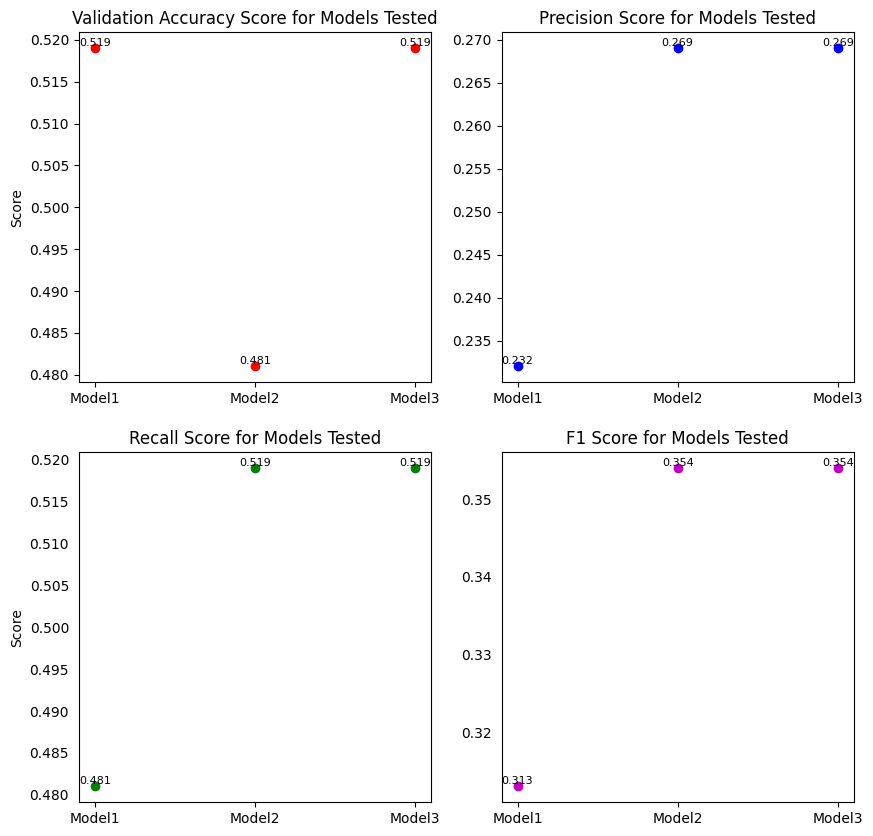

In [103]:
class_type = ['Model1', 'Model2', 'Model3']

fig_sc, ax_sc = plt.subplots(2,2, figsize=(10,10))

# Validation Accuracy
ax_sc[0,0].plot(class_type, scores, 'or')
for i in range(len(class_type)):
        ax_sc[0,0].text(i,scores[i],scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[0,0].set_xlabel('')
ax_sc[0,0].set_ylabel("Score")
ax_sc[0,0].set_title("Validation Accuracy Score for Models Tested")

# Precision
ax_sc[0,1].plot(class_type, precision_scores, 'ob')
for i in range(len(class_type)):
        ax_sc[0,1].text(i,precision_scores[i],precision_scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[0,1].set_xlabel('')
ax_sc[0,1].set_ylabel('')
ax_sc[0,1].set_title("Precision Score for Models Tested")

# Recall
ax_sc[1,0].plot(class_type, recall_scores, 'og')
for i in range(len(class_type)):
        ax_sc[1,0].text(i,recall_scores[i],recall_scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[1,0].set_ylabel('')
ax_sc[1,0].tick_params(axis='y', which='both',left=False)
ax_sc[1,0].set_ylabel("Score")
ax_sc[1,0].set_title("Recall Score for Models Tested")

# F1
ax_sc[1,1].plot(class_type, f1_scores, 'om')
for i in range(len(class_type)):
        ax_sc[1,1].text(i,f1_scores[i],f1_scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[1,1].set_ylabel('')
ax_sc[1,1].tick_params(axis='y', which='both',left=False)
ax_sc[1,1].set_title("F1 Score for Models Tested")

plt.show()

Overall, model 3 was the best model due to it having an equally good validation accuracy as model 1 and equally good F1, precision, and recall scores as model 2. Model 3 used the smalled batch size of 8 and had a learning rate of 0.00001.

**Hyperparameter Tuning Summary**

There were two different hyperparameters tuned for this model. The first was batch size when the model was being compiled. We tested batch sizes of 32, 16, and 8. The second was the learning rate which was adjusted automatically as the model was being fit. The learning rate started at 0.001 and progressed down to 0.000001 when the model reached a plateau.

**Troubleshooting**

It was difficult to find the proper hyperparameters to tune since it didn't seem like they were changing the outcomes of the models. Changing the batch size updated the models somewhat but the results were very similar. Trying to tune the optimizer didn't produce any different results either. Possible, using the pre-trained model restricted how much hyperparmater tuning would affect the model.

### Test Predictions

Now that we have determined the best model, we will create predictions based on the test set and submit them to kaggle.

In [16]:
submission = pd.read_csv("/content/nlp-getting-started/sample_submission.csv")
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [20]:
final_preds = model3.predict(x_test)
final_predictions = []
for y in final_preds:
  if y[0] >= 0.5:
    submission["target"] = 1
  else:
    submission["target"] = 0

102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step


In [22]:
submission.to_csv("/content/drive/MyDrive/Colab Notebooks/submission.csv", index = False, header = True)

## Conclusion

In conclusion, we created a NLP model to evaluate various texts of tweets to determine if they were related to a real disaster or not. We used the FNet NLP and tuned it on the batch size and the learning rate to determine the optimal parameters using the training set. Each model option was then evaluated against the validation set and the loss, accuracy, F1, precision, and recall scores were assessed. The best model was determined to be model 3 due to the highest validation loss and accuracy scores as  well as highest F1, precision, and accuracy scores. Using that model, we created predictions against the test set and the score of those predictions was determined to be 0.57033 in kaggle.

**Takeaways:**
*   The 3 model with a batch size of 8 and a learning rate of 0.00001 was the best model for this dataset.
*   Using pre-trained models made it difficult to get the hyperparamter tunings to affect the scores of the models.

**Improvements:**
*   Add in tuning other hyperparameters like the number of epochs or different optimizers.
*   Experiment with using other pre-built NLP models like BERT or Roberta to see how the performance compares to FNet.





